### Impact of Weather in Des Plains, IL on Ability to Fly Smaller Aircraft Locally
The data combines 10 years of hourly weather data and local flight counts at our local airport. This data will be used to determine if whether affects people's ability or desire to fly their plane. Consideration will be given to air pressure, temperature, wind speeds, and other weather attributes. Data will be consolidated to monthly, because the local airport does not provide daily flight counts.

**Author:** Don Price<br>
**Assignment:** Final Project<br>
**Class:** DSC 530<br>
**Last Updated:** 3/4/2022

In [72]:
from __future__ import print_function, division

import random

import thinkstats2
import thinkplot

import pandas as pd
import numpy as np

from scipy.stats import expon, pearsonr, spearmanr
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [73]:
os.getcwd()

'C:\\Users\\dfgpr\\OneDrive\\Don Masters Program\\Price_dsc530\\DSC530_Final_Project\\Data_Processing'

In [74]:
WEATHER_FILE = 'NOAA_localstation_download12.9.21_2815503.csv'

airport_df = pd.read_csv(WEATHER_FILE)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,21,27,28,29,30,31,32,33,37,38,42,43,44,49,50,52,54,56,57,59,60,61,62,63,64,96,114,115,118,120) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [75]:
# Review column options and data for model inclusion.

pd.options.display.max_columns = 500
airport_df.head()

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupElevationUnit,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,CDSD,CLDD,DSNW,DYHF,DYTS,DailyAverageDewPointTemperature,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyAverageSeaLevelPressure,DailyAverageStationPressure,DailyAverageWetBulbTemperature,DailyAverageWindSpeed,DailyCoolingDegreeDays,DailyDepartureFromNormalAverageTemperature,DailyHeatingDegreeDays,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindDirection,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,DailyWeather,HDSD,HTDD,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlySkyConditions,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,MonthlyAverageRH,MonthlyDaysWithGT001Precip,MonthlyDaysWithGT010Precip,MonthlyDaysWithGT32Temp,MonthlyDaysWithGT90Temp,MonthlyDaysWithLT0Temp,MonthlyDaysWithLT32Temp,MonthlyDepartureFromNormalAverageTemperature,MonthlyDepartureFromNormalCoolingDegreeDays,MonthlyDepartureFromNormalHeatingDegreeDays,MonthlyDepartureFromNormalMaximumTemperature,MonthlyDepartureFromNormalMinimumTemperature,MonthlyDepartureFromNormalPrecipitation,MonthlyDewpointTemperature,MonthlyGreatestPrecip,MonthlyGreatestPrecipDate,MonthlyGreatestSnowDepth,MonthlyGreatestSnowDepthDate,MonthlyGreatestSnowfall,MonthlyGreatestSnowfallDate,MonthlyMaxSeaLevelPressureValue,MonthlyMaxSeaLevelPressureValueDate,MonthlyMaxSeaLevelPressureValueTime,MonthlyMaximumTemperature,MonthlyMeanTemperature,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureValueDate,MonthlyMinSeaLevelPressureValueTime,MonthlyMinimumTemperature,MonthlySeaLevelPressure,MonthlyStationPressure,MonthlyTotalLiquidPrecipitation,MonthlyTotalSnowfall,MonthlyWetBulb,NormalsCoolingDegreeDay,NormalsHeatingDegreeDay,REM,REPORT_TYPE.1,SOURCE.1,ShortDurationEndDate005,ShortDurationEndDate010,ShortDurationEndDate015,ShortDurationEndDate020,ShortDurationEndDate030,ShortDurationEndDate045,ShortDurationEndDate060,ShortDurationEndDate080,ShortDurationEndDate100,ShortDurationEndDate120,ShortDurationEndDate150,ShortDurationEndDate180,ShortDurationPrecipitationValue005,ShortDurationPrecipitationValue010,ShortDurationPrecipitationValue015,ShortDurationPrecipitationValue020,ShortDurationPrecipitationValue030,ShortDurationPrecipitationValue045,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,WindEquipmentChangeDate
0,74466504838,2012-01-01T00:52:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.61,35.0,40,0,NaN,NaN,NaN,83.0,29.62,NaN,28.92,10,38.0,170,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET09701/01/12 00:52:02 METAR KPWK 010652Z 170...,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6/26/2007
1,74466504838,2012-01-01T01:52:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.56,35.0,42,0,NaN,NaN,NaN,76.0,29.57,NaN,28.87,10,39.0,170,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET09001/01/12 01:52:02 METAR KPWK 010752Z 170...,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

**Background on Data**
1) The data is organized by report type. A FM-15 record is a routine aviation record and should contain hourly measurements of weather. A FM-16 record is a special aviation report. Analysis will need to be conducted about whether this data is useful for parts of the intended analysis. Other types include 'SOD', which is a daily summary, and 'SOM', which is a summary of the month.

2) Data is a ten-year hourly average from 1/1/2012 to 12/7/2021.

3) Data is for the weather station located in Des Plaines, IL local airport.

In [76]:
# Types of Records Present in Dataset

airport_df['REPORT_TYPE'].unique()

array(['FM-15', 'FM-16', 'SOD  ', 'SOM  '], dtype=object)

In [77]:
# Dates present in the data set.

airport_df['DATE']

0         2012-01-01T00:52:00
1         2012-01-01T01:52:00
2         2012-01-01T02:52:00
3         2012-01-01T03:52:00
4         2012-01-01T04:52:00
                 ...         
116401    2021-12-06T23:52:00
116402    2021-12-06T23:59:00
116403    2021-12-07T00:52:00
116404    2021-12-07T01:52:00
116405    2021-12-07T02:52:00
Name: DATE, Length: 116406, dtype: object

### DATA PROCESSING

In [78]:
# Reprocess the date field to a Pandas datetime object. Add a field for month

airport_df['Date_Clean'] = pd.to_datetime(airport_df['DATE'])

In [79]:
airport_df['Date_Month'] = airport_df['Date_Clean'].dt.month
airport_df['Date_Day'] = airport_df['Date_Clean'].dt.day
airport_df['Date_Year'] = airport_df['Date_Clean'].dt.year

In [80]:
# Create tuple of day and month. This will be used to join airport data set to the monthly flight count data set.

airport_df['Date_Year_Month'] = list(zip(airport_df['Date_Year'], airport_df['Date_Month']))

In [81]:
# Change Field Values for Report Type field to remove extra spaces.
airport_df['REPORT_TYPE_Clean'] = airport_df['REPORT_TYPE'].str.strip()

In [82]:
# Dry Bulb Temperature is the temperature used most often. It is measured using a thermometer exposed to air but
# protected from moisture. Key fields are: 'DailyAverageDryBulbTemperature', 'DailyMaximumDryBulbTemperature', 'DailyMinimumDryBulbTemperature'.

# An "s" is appended to any value deemed to be suspect. Create a new column to exclude the 43 values where an "s" is
# shown for temperature. Most values are for June 2019, so we'll need to evaluate that month specifically.

airport_df['DailyAverageTemperature_Clean'] = airport_df['DailyAverageDryBulbTemperature']\
                                                        .map(lambda x: str(x).replace('s',''))\
                                                        .astype('float')

In [83]:
airport_df.loc[airport_df['REPORT_TYPE_Clean']=="SOM", ['DATE','Date_Month', 'Date_Day', 'Date_Year','Date_Year_Month']]

,DATE,Date_Month,Date_Day,Date_Year,Date_Year_Month
999,2012-01-31T23:59:00,1,31,2012,"(2012, 1)"
1945,2012-02-29T23:59:00,2,29,2012,"(2012, 2)"
2911,2012-03-31T23:59:00,3,31,2012,"(2012, 3)"
3771,2012-04-30T23:59:00,4,30,2012,"(2012, 4)"
4708,2012-05-31T23:59:00,5,31,2012,"(2012, 5)"
...,...,...,...,...,...
112422,2021-07-31T23:59:00,7,31,2021,"(2021, 7)"
113356,2021-08-31T23:59:00,8,31,2021,"(2021, 8)"
114195,2021-09-30T23:59:00,9,30,2021,"(2021, 9)"
115321,2021-10-31T23:59:00,10,31,2021,"(2021, 10)"


In [84]:
# Clean 'MonthlyTotalLiquidPrecipitation' and convert to numerical values.

airport_df['MonthlyTotalLiquidPrecipitation_Clean'] = airport_df['MonthlyTotalLiquidPrecipitation']\
                                                        .map(lambda x: str(x).replace('T','0'))

airport_df['MonthlyTotalLiquidPrecipitation_Clean'] = airport_df['MonthlyTotalLiquidPrecipitation_Clean']\
                                                        .map(lambda x: str(x).replace('s',''))\
                                                        .astype('float')

In [85]:
# Clean 'MonthlyDaysWithLT32Temp' and convert to numerical values.

airport_df['MonthlyDaysWithLT32Temp_Clean'] = airport_df['MonthlyDaysWithLT32Temp']\
                                                        .map(lambda x: str(x).replace('s',''))\
                                                        .astype('float')

In [86]:
# Add variable for Wind Gust Count where Peak Wind Speed Exceeds 30mph
airport_df['DailyPeakWindSpeed_Clean'] = airport_df['DailyPeakWindSpeed'].map(lambda x: str(x).replace('*','0'))

airport_df['DailyPeakWindSpeed_Clean'] = airport_df['DailyPeakWindSpeed_Clean']\
                                            .map(lambda x: str(x).replace('s',''))\
                                            .astype('float')

airport_df['Wind_Gust_Count'] = ['1' if x>30 else '0' for x in airport_df['DailyPeakWindSpeed_Clean']]\

airport_df['Wind_Gust_Count'] = airport_df['Wind_Gust_Count'].astype(float)

In [87]:
# Wind Gust Count is calculated on a daily basis. Need to aggregate and append to monthly attributes.
WindGustOver30_df = airport_df.groupby('Date_Year_Month')['Wind_Gust_Count'].sum()

In [88]:
# Add Seasonal Calculation to Segment Variables for Winter and Other Seasons. Set winter to months 1, 2, and 12 (see CDF).

airport_df['Season'] = "Not Winter"

airport_df.loc[airport_df['Date_Month'].isin([1,2,12]),['Season']] = "Winter"

### APPENDING LOCAL FLIGHTS

**Background on Flight Data**
Chicago Executive Airport publishes data on the number of flights from the airport. The data is presented monthly. Flight counts are separated into itenerant and local flights. My interest is in the local flights as those align to my intended use. Itenerant flights include larger, executive plans more capable of flying in tougher elements than planes used for local flights. 

Local flight counts will be the target variable for this analysis.

Link to the data file: https://www.chiexec.com/chicago-executive-airport-traffic-statistics

In [89]:
FLIGHT_FILE = "CEAflightcount.csv"

flight_df = pd.read_csv(FLIGHT_FILE)

In [90]:
# Create a year and month tuple to join data sets.

flight_df['Date_Year_Month'] = list(zip(flight_df['Year'], flight_df['Month']))

In [91]:
flight_df.head()

,Date,Month,Year,Itinerant,Local,Total Operations,Date_Year_Month
0,1/1/2021,1,2021,3824,1810,5634,"(2021, 1)"
1,2/1/2021,2,2021,3479,1375,4854,"(2021, 2)"
2,3/1/2021,3,2021,5379,1649,7028,"(2021, 3)"
3,4/1/2021,4,2021,5487,2027,7514,"(2021, 4)"
4,5/1/2021,5,2021,6529,2860,9389,"(2021, 5)"


In [92]:
combined_df = airport_df.merge(flight_df, how='left', on='Date_Year_Month')

In [93]:
# Verify shape of pre and post merged data sets. 6 columns added; no rows duplicated.

airport_df.shape, combined_df.shape

((116406, 136), (116406, 142))

### BUILD MONTHLY MODEL DATA SET

In [94]:
# Select target variable and model columns

model_df = combined_df.loc[combined_df['REPORT_TYPE_Clean']=="SOM",
                          ['Date_Year_Month', 'Local', 'Season', 'MonthlyMeanTemperature', 'MonthlyDaysWithLT32Temp_Clean', 
                           'MonthlyTotalLiquidPrecipitation_Clean', 'MonthlySeaLevelPressure']
                          ]

In [95]:
# Append wind gust data frome.

model_df = model_df.merge(WindGustOver30_df, how='left', on='Date_Year_Month')

In [96]:
# Remove any Rows with Null Values and resave dataframe. Removed 27 rows and kept 90. All but 3 rows were 
# removed because flight data was not available.

is_nulls = model_df.isnull().any(axis=1)
model_df = model_df.loc[is_nulls!=True]

model_df = model_df.reset_index()

In [97]:
# Data factors and basic statistics

model_df.describe()

,index,Local,MonthlyMeanTemperature,MonthlyDaysWithLT32Temp_Clean,MonthlyTotalLiquidPrecipitation_Clean,MonthlySeaLevelPressure,Wind_Gust_Count
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,70.900000,1782.988889,50.938889,3.011111,2.876222,30.039889,6.877778
std,26.857113,615.412778,17.901671,5.206941,2.195644,0.079641,3.034734
min,25.000000,556.000000,14.900000,0.000000,0.000000,29.860000,0.000000
25%,47.250000,1368.250000,35.000000,0.000000,1.240000,29.972500,5.000000
50%,71.500000,1679.500000,51.600000,0.000000,2.395000,30.035000,6.000000
75%,93.750000,2147.250000,69.275000,5.000000,4.022500,30.097500,9.000000
max,116.000000,3412.000000,78.300000,25.000000,9.750000,30.210000,14.000000


### EDA: Histogram of Model Statistics

In [98]:
# Develop a function for histograms

def HistogramStats(var, bins=20, title='', xl='', yl='Count'):
    fig=plt.figure(figsize=(12,4))
    plt.hist(var, bins=bins);
    plt.title(title);
    plt.xlabel(xl);
    plt.ylabel(yl);
    return(var.describe())

count    90.000000
mean     50.938889
std      17.901671
min      14.900000
25%      35.000000
50%      51.600000
75%      69.275000
max      78.300000
Name: MonthlyMeanTemperature, dtype: float64

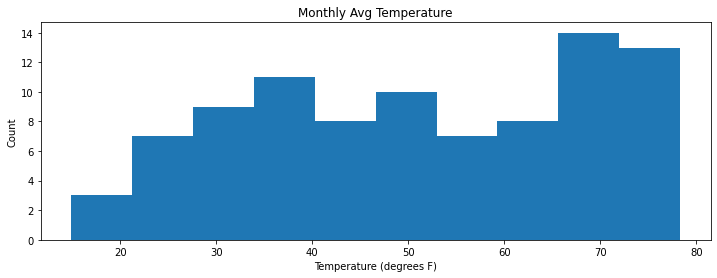

In [99]:
HistogramStats(var=model_df['MonthlyMeanTemperature'], bins=10, 
               title='Monthly Avg Temperature', xl='Temperature (degrees F)')

count    90.000000
mean      3.011111
std       5.206941
min       0.000000
25%       0.000000
50%       0.000000
75%       5.000000
max      25.000000
Name: MonthlyDaysWithLT32Temp_Clean, dtype: float64

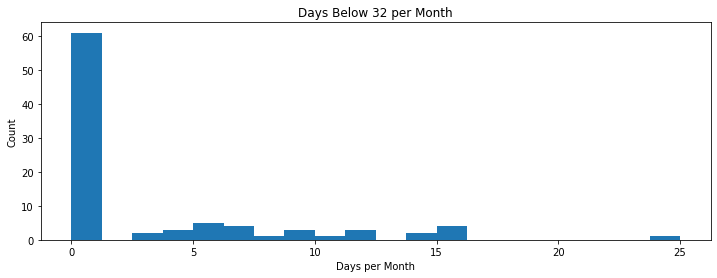

In [100]:
HistogramStats(var=model_df['MonthlyDaysWithLT32Temp_Clean'], bins=20, 
               title='Days Below 32 per Month', xl='Days per Month')

In [101]:
# Chicago weather was one of the coldest temperatures on record as it was impacted by the polar vortex event.
# https://en.wikipedia.org/wiki/February_2015_North_American_cold_wave
# Local weather validation: https://www.nbcchicago.com/news/local/record-cold-february-2015/1993156/#:~:text=Published%20March%206%2C%202015,a%20cold%20last%20three%20months.

model_df.loc[model_df['MonthlyDaysWithLT32Temp_Clean']>10, 
            ['Date_Year_Month', 'MonthlyDaysWithLT32Temp_Clean', 'MonthlyMeanTemperature']]\
.sort_values(by=['MonthlyDaysWithLT32Temp_Clean'], ascending=False)

,Date_Year_Month,MonthlyDaysWithLT32Temp_Clean,MonthlyMeanTemperature
12,"(2015, 2)",25.0,14.9
57,"(2019, 1)",16.0,22.3
80,"(2021, 2)",16.0,19.5
23,"(2016, 1)",15.0,24.8
45,"(2018, 1)",15.0,25.1
11,"(2015, 1)",14.0,22.5
32,"(2016, 12)",14.0,25.5
9,"(2014, 11)",12.0,34.2
44,"(2017, 12)",12.0,27.3
58,"(2019, 2)",12.0,26.5


count    90.000000
mean      2.876222
std       2.195644
min       0.000000
25%       1.240000
50%       2.395000
75%       4.022500
max       9.750000
Name: MonthlyTotalLiquidPrecipitation_Clean, dtype: float64

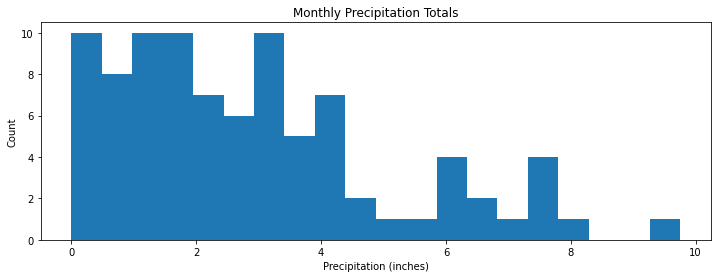

In [102]:
HistogramStats(var=model_df['MonthlyTotalLiquidPrecipitation_Clean'], 
          title='Monthly Precipitation Totals', xl='Precipitation (inches)')

count    90.000000
mean     30.039889
std       0.079641
min      29.860000
25%      29.972500
50%      30.035000
75%      30.097500
max      30.210000
Name: MonthlySeaLevelPressure, dtype: float64

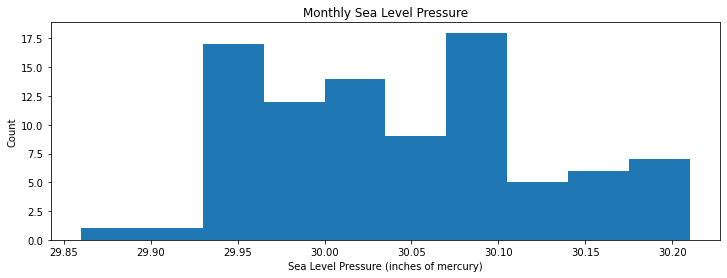

In [103]:
HistogramStats(var=model_df['MonthlySeaLevelPressure'], bins=10,
          title='Monthly Sea Level Pressure', xl='Sea Level Pressure (inches of mercury)')

count    90.000000
mean      6.877778
std       3.034734
min       0.000000
25%       5.000000
50%       6.000000
75%       9.000000
max      14.000000
Name: Wind_Gust_Count, dtype: float64

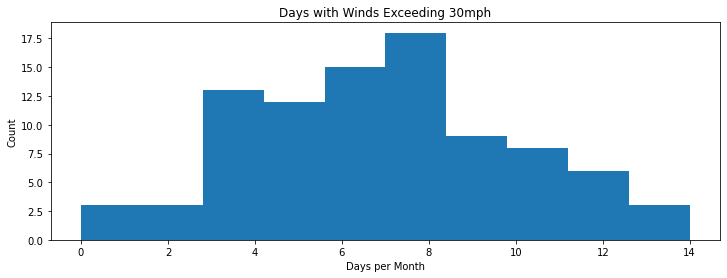

In [104]:
HistogramStats(var=model_df['Wind_Gust_Count'], bins=10, title='Days with Winds Exceeding 30mph', xl='Days per Month')

### EDA: Analysis of Daily Average Temperature (combined_df)

In [105]:
# Filter data set on daily info
combined_df_daily = combined_df.loc[airport_df['REPORT_TYPE_Clean']=='SOD']

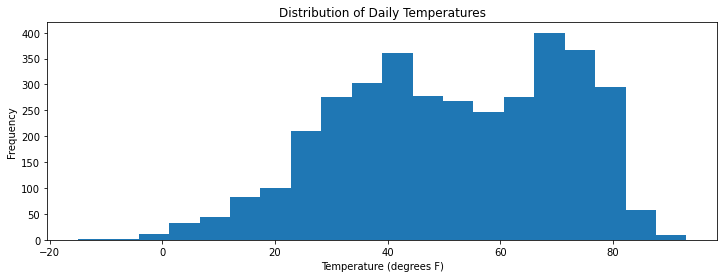

In [106]:
fig=plt.figure(figsize=(12,4))
plt.hist(combined_df_daily['DailyAverageTemperature_Clean'], bins=20);
plt.title("Distribution of Daily Temperatures");
plt.xlabel("Temperature (degrees F)");
plt.ylabel("Frequency");

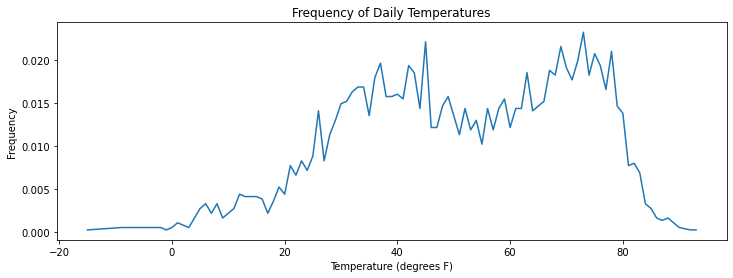

In [107]:
temp_frequency = combined_df_daily['DailyAverageTemperature_Clean'].value_counts(normalize=True)
temp_frequency = temp_frequency.sort_index()

fig=plt.figure(figsize=(12,4))
plt.plot(temp_frequency);
plt.title("Frequency of Daily Temperatures");
plt.xlabel("Temperature (degrees F)");
plt.ylabel("Frequency");

In [108]:
# Group data by month of year so we can understand temperature ranges by month.

temp_frequency_bymonth = combined_df_daily[['Date_Month','DailyAverageTemperature_Clean']]\
                             .value_counts()\
                             .reset_index()\
                             .sort_values('DailyAverageTemperature_Clean',ascending=True)\
                             .rename(columns={0: 'TempFrequency'})

# Add frequency for the temperatures by month
temp_frequency_bymonth['Frequency_Month'] = temp_frequency_bymonth.groupby('Date_Month')['TempFrequency'].transform(lambda x: (x / x.sum()))

# Add cumulative sum of temperatures by month
temp_frequency_bymonth['CUM_Frequency_Month'] = temp_frequency_bymonth.groupby('Date_Month')['Frequency_Month'].transform(lambda x: (np.cumsum(x)))

temp_frequency_bymonth.head()

,Date_Month,DailyAverageTemperature_Clean,TempFrequency,Frequency_Month,CUM_Frequency_Month
454,1,-15.0,1,0.003247,0.003247
439,1,-9.0,2,0.006494,0.009740
381,1,-4.0,2,0.006494,0.016234
486,1,-2.0,1,0.003247,0.019481
480,2,-2.0,1,0.003559,0.003559


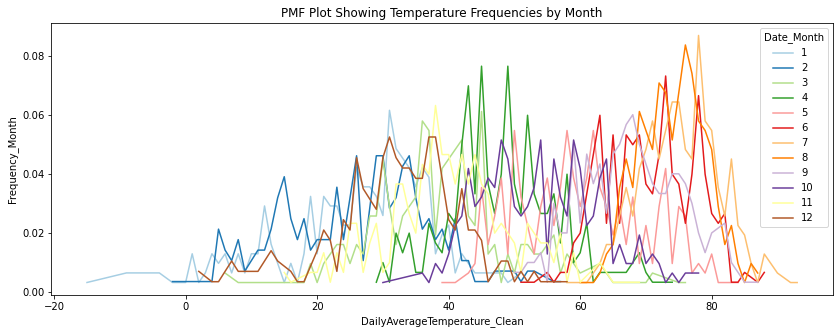

In [109]:
# PDF of temperatures, separated by month

fig=plt.figure(figsize=(14,5))
colors = sns.color_palette("Paired", 12)

sns.lineplot(x='DailyAverageTemperature_Clean', y='Frequency_Month', data=temp_frequency_bymonth, 
             hue='Date_Month', palette=colors);
plt.title('PMF Plot Showing Temperature Frequencies by Month');

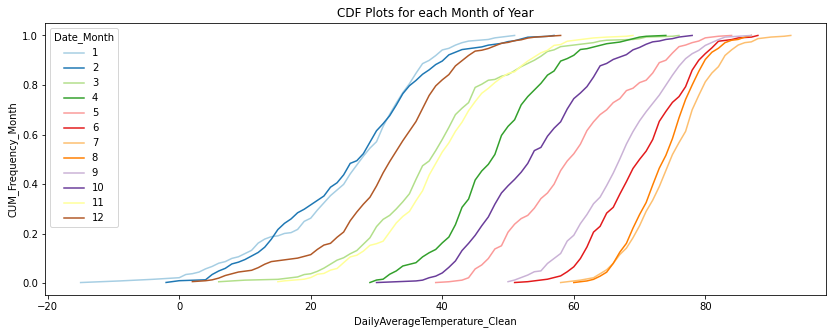

In [110]:
# Graph the CDF of the daily temperature by month. Months demonstrate different ranges of values.

fig=plt.figure(figsize=(14,5))

sns.lineplot(x='DailyAverageTemperature_Clean', y='CUM_Frequency_Month', data=temp_frequency_bymonth, 
             hue='Date_Month',palette=colors);
plt.title('CDF Plots for each Month of Year');

In [111]:
# Determine the central tendencies and variance statistics of temperature by month.

combined_df.groupby('Date_Month')['DailyAverageTemperature_Clean'].describe()

,count,mean,std,min,25%,50%,75%,max
Date_Month,,,,,,,,
1,308.0,25.922078,11.678948,-15.0,19.75,28.0,34.0,51.0
2,281.0,26.387900,11.677928,-2.0,17.00,28.0,34.0,57.0
3,310.0,38.935484,11.470055,6.0,31.00,39.0,45.0,76.0
4,300.0,48.156667,8.574216,29.0,43.00,48.0,53.0,74.0
5,310.0,60.274194,9.808472,39.0,52.00,60.0,68.0,84.0
6,300.0,70.490000,7.083111,51.0,65.00,70.5,76.0,88.0
7,310.0,75.193548,6.154533,58.0,71.00,75.0,79.0,93.0
8,310.0,73.958065,5.225174,60.0,70.00,74.0,78.0,87.0
9,299.0,67.454849,7.603898,50.0,62.00,67.0,73.0,87.0


### EDA: Separating Temperature for Winter Months

In [112]:
winter_df = model_df.loc[model_df['Season']=='Winter']
notwinter_df = model_df.loc[model_df['Season']!='Winter']

In [113]:
# Group data by season so we can understand the monthly temperatures for winter and other months.

temp_frequency_season = model_df[['Season','MonthlyMeanTemperature']]\
                             .value_counts()\
                             .reset_index()\
                             .sort_values('MonthlyMeanTemperature',ascending=True)\
                             .rename(columns={0: 'TempFrequency'})

# Add frequency for the temperatures by month
temp_frequency_season['Frequency_Month'] = temp_frequency_season.groupby('Season')['TempFrequency'].transform(lambda x: (x / x.sum()))

# Add cumulative sum of temperatures by month
temp_frequency_season['CUM_Frequency_Month'] = temp_frequency_season.groupby('Season')['Frequency_Month'].transform(lambda x: (np.cumsum(x)))

temp_frequency_season.head()

,Season,MonthlyMeanTemperature,TempFrequency,Frequency_Month,CUM_Frequency_Month
17,Winter,14.9,1,0.047619,0.047619
42,Winter,17.4,1,0.047619,0.095238
24,Winter,19.5,1,0.047619,0.142857
41,Winter,22.3,1,0.047619,0.190476
40,Winter,22.5,1,0.047619,0.238095


<Figure size 1008x360 with 0 Axes>

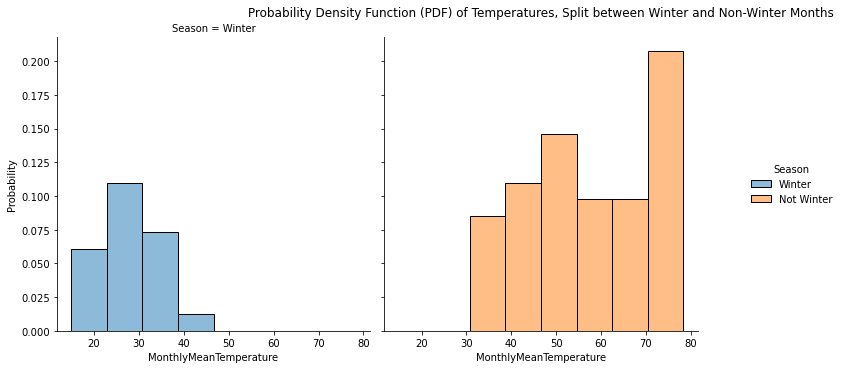

In [114]:
# Graph the PMFs for winter and other seasons

plt.figure(figsize=(14,5))

sns.displot(data=temp_frequency_season, x='MonthlyMeanTemperature', col="Season", hue='Season', stat="probability");
plt.title('Probability Density Function (PDF) of Temperatures, Split between Winter and Non-Winter Months\n');

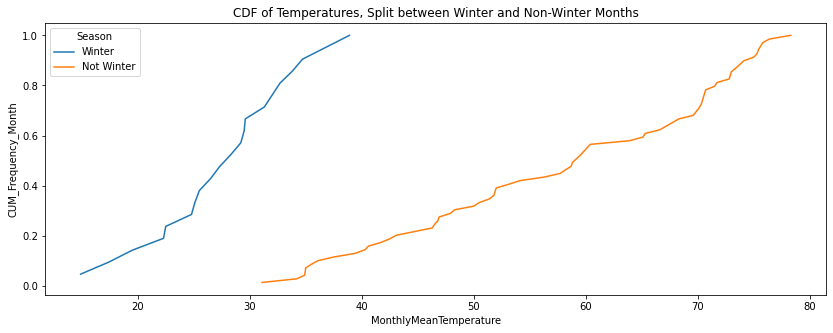

In [115]:
# Graph the CDFs for winter and other seasons

plt.figure(figsize=(14,5))

sns.lineplot(data=temp_frequency_season, x='MonthlyMeanTemperature', y="CUM_Frequency_Month", hue="Season");
plt.title('CDF of Temperatures, Split between Winter and Non-Winter Months');

In [116]:
# Statistics of winter and non-winter periods.

winter_temp = winter_df['MonthlyMeanTemperature'].dropna()
notwinter_temp = notwinter_df['MonthlyMeanTemperature'].dropna()

table1 = pd.DataFrame(data={'Winter Season': winter_temp.describe(), 'Not Winter Season': notwinter_temp.describe()})
print(f"Comparison of Temperatures During Winter Season (Nov-Dec) and Non-Winter Months\n")
print(table1)

Comparison of Temperatures During Winter Season (Nov-Dec) and Non-Winter Months

       Winter Season  Not Winter Season
count      21.000000          69.000000
mean       27.742857          57.998551
std         6.226200          13.831151
min        14.900000          31.100000
25%        24.800000          46.800000
50%        28.300000          59.500000
75%        32.000000          70.600000
max        38.900000          78.300000


In [117]:
# Group data by season so we can understand the flights for winter and other months.

temp_flights = model_df[['Season','Local']]\
                             .value_counts()\
                             .reset_index()\
                             .sort_values('Local',ascending=True)\
                             .rename(columns={0: 'TempFrequency'})

# Add frequency for the temperatures by month
temp_flights['Frequency_Month'] = temp_flights.groupby('Season')['TempFrequency'].transform(lambda x: (x / x.sum()))

# Add cumulative sum of temperatures by month
temp_flights['CUM_Frequency_Month'] = temp_flights.groupby('Season')['Frequency_Month'].transform(lambda x: (np.cumsum(x)))

temp_flights.head()

,Season,Local,TempFrequency,Frequency_Month,CUM_Frequency_Month
24,Winter,556.0,1,0.047619,0.047619
43,Winter,636.0,1,0.047619,0.095238
0,Not Winter,786.0,1,0.014493,0.014493
42,Winter,822.0,1,0.047619,0.142857
41,Winter,900.0,1,0.047619,0.190476


<Figure size 1008x360 with 0 Axes>

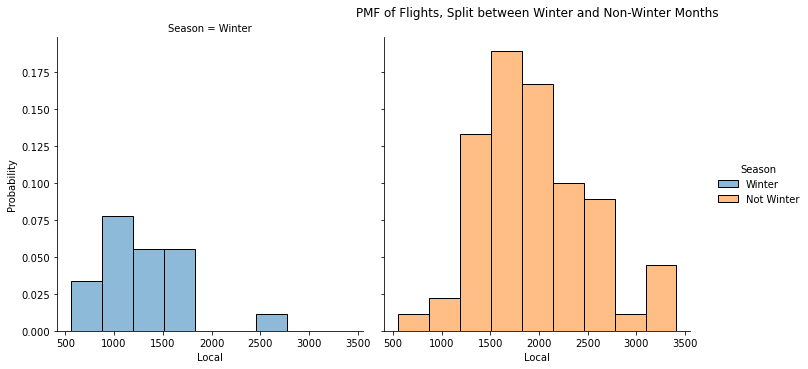

In [118]:
# Graph the CDFs for winter and other seasons

plt.figure(figsize=(14,5))

sns.displot(data=temp_flights, x='Local', col="Season", hue='Season', stat="probability");
plt.title('PMF of Flights, Split between Winter and Non-Winter Months\n');

### EDA: PMF of a Variable (Precipitation Amount)

In [119]:
# Group data by month of year so we can understand temperature ranges by month.

temp_precip = model_df[['MonthlyTotalLiquidPrecipitation_Clean']]\
                             .value_counts()\
                             .reset_index()\
                             .sort_values('MonthlyTotalLiquidPrecipitation_Clean',ascending=True)\
                             .rename(columns={0: 'TempCounts'})

temp_precip = temp_precip.reset_index()

# Add frequency for the temperatures by month
temp_precip['Frequency'] = temp_precip['TempCounts'].transform(lambda x: (x / x.sum()))

# Add cumulative sum of temperatures by month
temp_precip['CUM_Frequency'] = np.cumsum(temp_precip['Frequency'])

temp_precip.head()

,index,MonthlyTotalLiquidPrecipitation_Clean,TempCounts,Frequency,CUM_Frequency
0,0,0.00,2,0.022222,0.022222
1,54,0.02,1,0.011111,0.033333
2,61,0.19,1,0.011111,0.044444
3,60,0.20,1,0.011111,0.055556
4,59,0.26,1,0.011111,0.066667


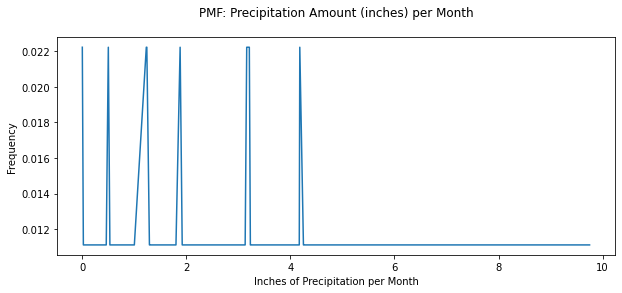

In [120]:
# Probability Mass Function (PMF): Calculation for Variable where Count of Freezing Days / Month

fig=plt.figure(figsize=(10,4))

sns.lineplot(x='MonthlyTotalLiquidPrecipitation_Clean', y='Frequency', data=temp_precip);
plt.title('PMF: Precipitation Amount (inches) per Month\n');
plt.xlabel('Inches of Precipitation per Month');

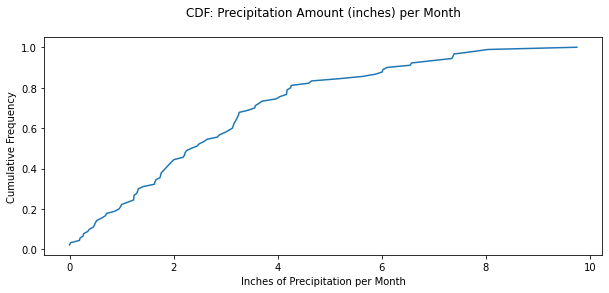

In [121]:
# CDF: Calculation for Variable where Count of Freezing Days / Month

fig=plt.figure(figsize=(10,4))

sns.lineplot(x='MonthlyTotalLiquidPrecipitation_Clean', y='CUM_Frequency', data=temp_precip);
plt.title('CDF: Precipitation Amount (inches) per Month\n');
plt.xlabel('Inches of Precipitation per Month');
plt.ylabel('Cumulative Frequency');

### EDA: Create an Estimated Model for Precipitation Amount

In [122]:
# Statistical variables for Precipitation

model_df['MonthlyTotalLiquidPrecipitation_Clean'].describe()

count    90.000000
mean      2.876222
std       2.195644
min       0.000000
25%       1.240000
50%       2.395000
75%       4.022500
max       9.750000
Name: MonthlyTotalLiquidPrecipitation_Clean, dtype: float64

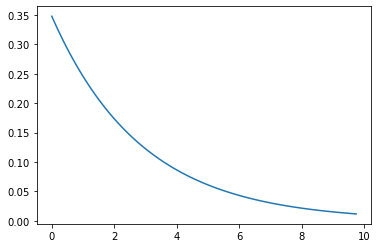

In [123]:
# Build an Exponential Model using Statistics of Total Precipitation per Month

mu = model_df['MonthlyTotalLiquidPrecipitation_Clean'].mean()
sigma = model_df['MonthlyTotalLiquidPrecipitation_Clean'].std()

mn = model_df['MonthlyTotalLiquidPrecipitation_Clean'].min()
mx = model_df['MonthlyTotalLiquidPrecipitation_Clean'].max()

mu, sigma, mn, mx

x = np.linspace(mn, mx, num=100)
sns.lineplot(x=x, y=expon.pdf(x, 0, mu));

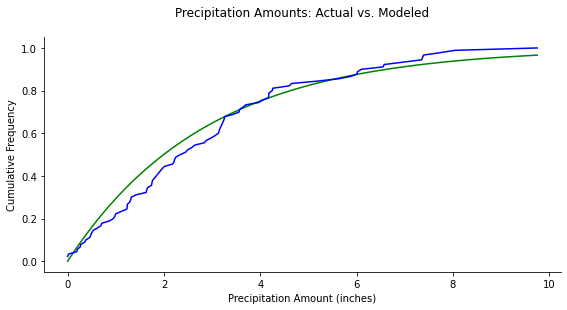

In [124]:
# Compare an Exponential Distribution to the Precipitation Amount

g = sns.FacetGrid(temp_precip, height=4, aspect=2);
g.map(sns.lineplot, x=x, y=expon.cdf(x, 0, mu), color='g');
g.map(sns.lineplot, x='MonthlyTotalLiquidPrecipitation_Clean', y='CUM_Frequency', data=temp_precip, color="b");
plt.title('Precipitation Amounts: Actual vs. Modeled\n');
plt.xlabel('Precipitation Amount (inches)');
plt.ylabel('Cumulative Frequency');

### EDA: Scatterplot Construction

In [125]:
# Function used to create scatterplots and correlation

def Scatter_Target(df, x_var, y_var):
    sns.scatterplot(data=df, x=x_var, y=y_var);
    
    pears = pearsonr(df[x_var], df[y_var])[0]
    sp_rank = spearmanr(df[x_var], df[y_var])[0]
    print(f'Pearsons R:',pears,'\nSpearman\'s Rank Corr:',sp_rank)
    

Pearsons R: 0.1754075686588556 
Spearman's Rank Corr: 0.22354936174975182


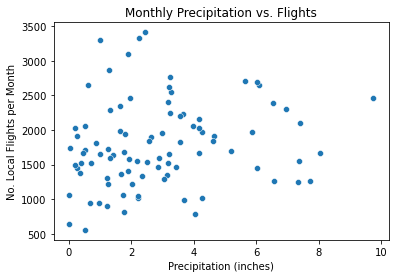

In [126]:
# Amount of Precipitation not likely useful in projecting the number of flights.

Scatter_Target(df=model_df, x_var='MonthlyTotalLiquidPrecipitation_Clean', y_var='Local')
plt.title('Monthly Precipitation vs. Flights');
plt.ylabel('No. Local Flights per Month');
plt.xlabel('Precipitation (inches)');

Pearsons R: -0.20428707108218086 
Spearman's Rank Corr: -0.2083003358340539


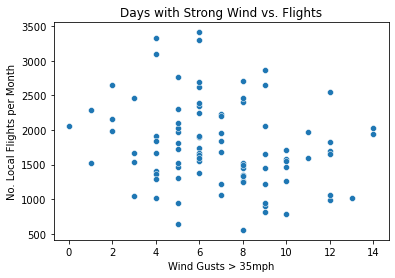

In [127]:
# Wind Gust Counts not likely useful in projecting the number of flights.

Scatter_Target(df=model_df, x_var='Wind_Gust_Count', y_var='Local')
plt.title('Days with Strong Wind vs. Flights');
plt.ylabel('No. Local Flights per Month');
plt.xlabel('Wind Gusts > 35mph');

Pearsons R: -0.38702461162100077 
Spearman's Rank Corr: -0.36359467239308957


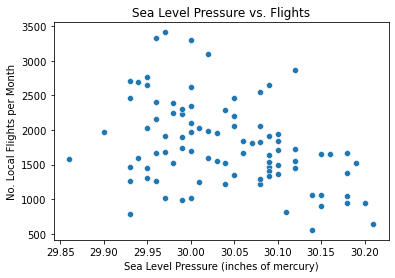

In [128]:
# Air pressure not likely useful in projecting the number of flights.

Scatter_Target(df=model_df, x_var='MonthlySeaLevelPressure', y_var='Local');
plt.title('Sea Level Pressure vs. Flights');
plt.ylabel('No. Local Flights per Month');
plt.xlabel('Sea Level Pressure (inches of mercury)');

Pearsons R: -0.547113276659184 
Spearman's Rank Corr: -0.5729936557073562


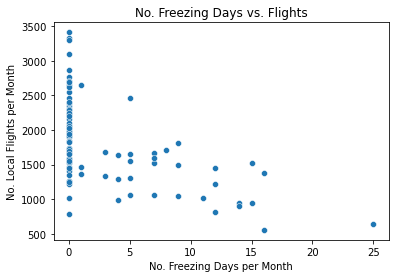

In [129]:
# Days below freezing seems to be moderately useful variable for projecting flights.

Scatter_Target(df=model_df, x_var='MonthlyDaysWithLT32Temp_Clean', y_var='Local');
plt.title('No. Freezing Days vs. Flights');
plt.ylabel('No. Local Flights per Month');
plt.xlabel('No. Freezing Days per Month');

Pearsons R: 0.6823059764240034 
Spearman's Rank Corr: 0.7005186044787757


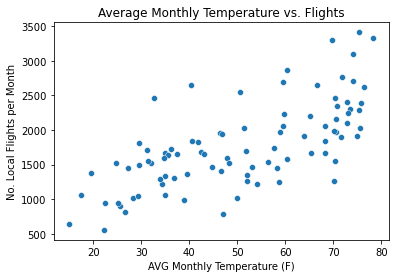

In [130]:
# Average Monthly Temperature seems to be the most useful variable for projecting flight conditions.

Scatter_Target(df=model_df, x_var='MonthlyMeanTemperature', y_var='Local');
plt.title('Average Monthly Temperature vs. Flights');
plt.ylabel('No. Local Flights per Month');
plt.xlabel('AVG Monthly Temperature (F)');

Pearsons R: -0.7765520906220109 
Spearman's Rank Corr: -0.8421254020573953


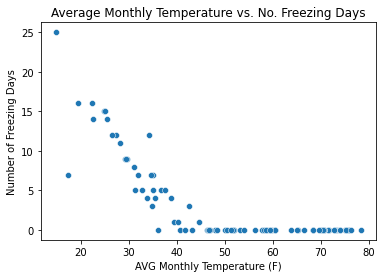

In [131]:
# Correlation Among 2 Temperature Variables Probably Too High to include Both in Model

Scatter_Target(df=model_df, x_var='MonthlyMeanTemperature', y_var='MonthlyDaysWithLT32Temp_Clean');
plt.title('Average Monthly Temperature vs. No. Freezing Days');
plt.ylabel('Number of Freezing Days');
plt.xlabel('AVG Monthly Temperature (F)');

In [132]:
# Monthly Mean Temperature is inversely correlated with Number of Days Below Freezing. 
# Higher Spearman value suggests trend is non-linear. P-values are not significant at even 10% level, so this relationship
# is questionable or perhaps more complex.

pears = pearsonr(model_df['MonthlyMeanTemperature'], model_df['MonthlyDaysWithLT32Temp_Clean'])[0]
pears_pval = pearsonr(model_df['MonthlyMeanTemperature'], model_df['MonthlyDaysWithLT32Temp_Clean'])[1]
sprank = spearmanr(model_df['MonthlyMeanTemperature'], model_df['MonthlyDaysWithLT32Temp_Clean'])[0]
sp_pval = spearmanr(model_df['MonthlyMeanTemperature'], model_df['MonthlyDaysWithLT32Temp_Clean'])[1]

print(f'Pearsons R:',pears,'\nPearson p-value:',pears_pval,'\nSpearman R:',sprank,'\nSpearman p-value:',sp_pval)

Pearsons R: -0.7765520906220109 
Pearson p-value: 2.400817639134111e-19 
Spearman R: -0.8421254020573953 
Spearman p-value: 2.5171816646761668e-25


### EDA: Hypothesis Testing

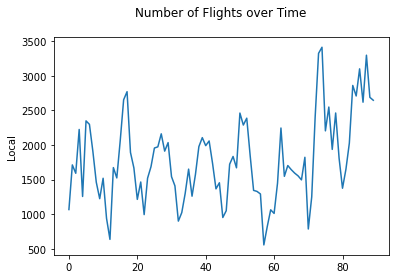

In [133]:
# Review the Trend in Local Data

time_months = model_df.index

sns.lineplot(x=model_df.index, y='Local', data=model_df);
plt.title('Number of Flights over Time\n');

In [134]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

In [135]:
# Difference of means function.

class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [136]:
# Run a difference of means test to see if the number of flights in more recent years differs from history.
# Testing whether first five years (60 months) differ from later years.

early_years = model_df.loc[model_df.index<60]
later_years = model_df.loc[model_df.index>=60]
data = early_years['Local'], later_years['Local']

ht = DiffMeansPermute(data)
pvalue = ht.PValue()

print('Comparing the mean number of flights between 2014-2018 vs. 2019-2021 demonstrates means are similar')
print('less than 1% of the time. This is significant.')
print(f'pvalue from difference in means test=', pvalue)

Comparing the mean number of flights between 2014-2018 vs. 2019-2021 demonstrates means are similar
less than 1% of the time. This is significant.
pvalue from difference in means test= 0.0


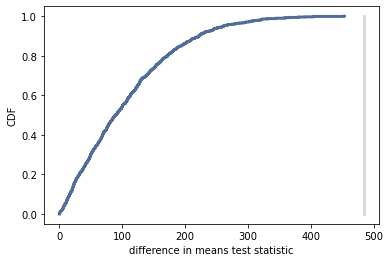

<Figure size 576x432 with 0 Axes>

In [137]:
ht.PlotCdf();
thinkplot.Show(xlabel='difference in means test statistic', ylabel='CDF');

### REGRESSION: Build Linear Model with Temperature as only Variable

In [138]:
# Build Model with Temperature as only Independent Variable. Predict Local Flights

x_val = np.array(model_df['MonthlyMeanTemperature']).reshape(-1,1)
y_actual = np.array(model_df['Local'])

lm = linear_model.LinearRegression()
lm.fit(X=x_val, y=y_actual)
y_pred = lm.predict(x_val)

In [139]:
# The coefficients and intercept
print("Coefficients: ", lm.coef_)
print("Intercept: ", lm.intercept_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_actual, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_actual, y_pred))

Coefficients:  [23.45590086]
Intercept:  588.1713612573142
Mean squared error: 200167.95
Coefficient of determination: 0.47


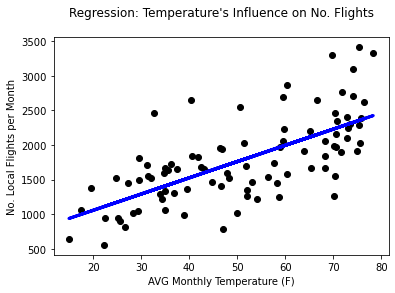

In [140]:
# Plot outputs
plt.scatter(x_val, y_actual, color="black");
plt.plot(x_val, y_pred, color="blue", linewidth=3);
plt.title('Regression: Temperature\'s Influence on No. Flights\n');
plt.ylabel('No. Local Flights per Month');
plt.xlabel('AVG Monthly Temperature (F)');